In [1]:
"""!pip install -U tensorflow==2.10.0 keras==2.10.0 segmentation-models==1.0.1
"""

'!pip install -U tensorflow==2.10.0 keras==2.10.0 segmentation-models==1.0.1\n'

In [2]:
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from zipfile import ZipFile
import cv2
import os
from pylab import rcParams
from sklearn.model_selection import train_test_split
import imgaug as ia
import imgaug.augmenters as iaa
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from keras.optimizers import Adam
from keras import backend as K
import segmentation_models as sm

print("TensorFlow Version: ", tf.__version__)
print("Eager Execution: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")


Segmentation Models: using `keras` framework.
TensorFlow Version:  2.10.0
Eager Execution:  True
GPU is NOT AVAILABLE


In [3]:
import pandas as pd
import os

# Replace with the path to your dataset
metadata_path = "/content/drive/MyDrive/MLProject/metadata.csv"
raw_data = pd.read_csv(metadata_path)

# Display the first few rows of metadata to confirm successful loading
print("Metadata loaded successfully:")
raw_data.head()


Metadata loaded successfully:


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
1,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
2,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
3,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
4,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...


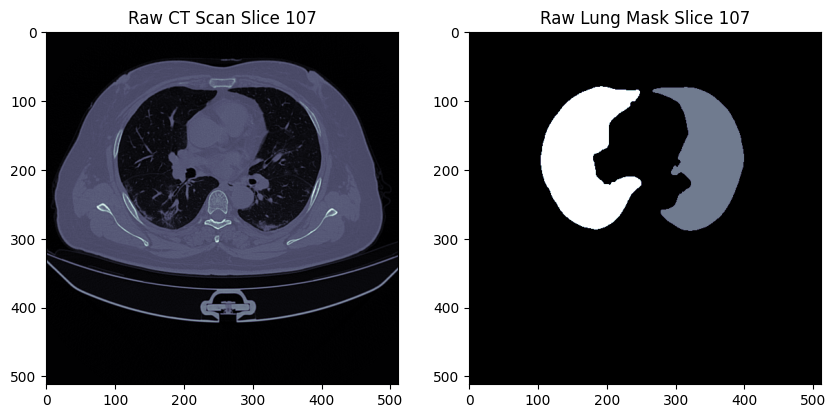

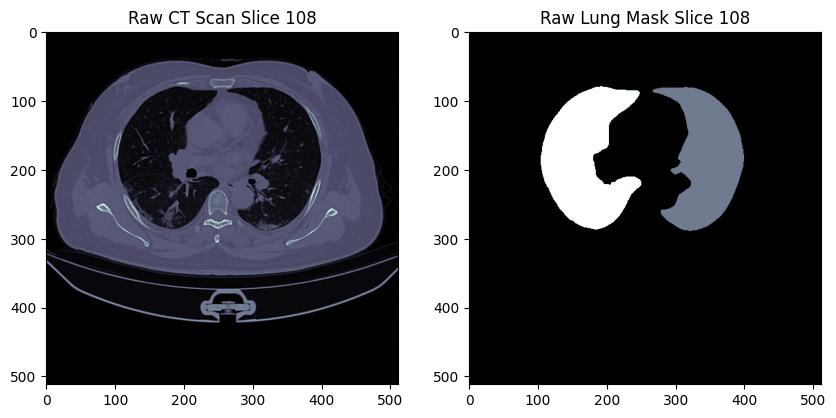

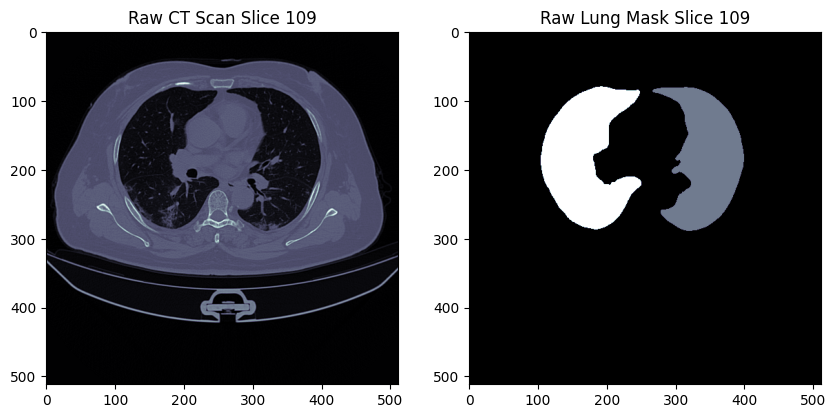

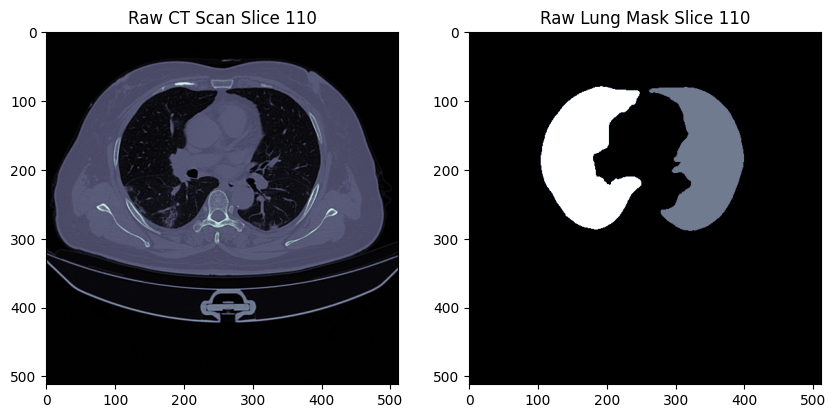

Number of CT Scans: 2112
Number of Lung Masks: 2112


In [4]:
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Set the preferred image size
img_size = 512

# CLAHE (Contrast Limited Adaptive Histogram Equalization) Function
def clahe_enhancer(test_img, demo=False):
    test_img = test_img * 255
    test_img = np.uint8(test_img)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(test_img)

    if demo:
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(test_img, cmap='bone')
        plt.title("Original Image")

        plt.subplot(1, 2, 2)
        plt.imshow(clahe_image, cmap='bone')
        plt.title("CLAHE Enhanced Image")
        plt.show()

    return clahe_image

# Function to read `.nii` files and preprocess
def read_nii_demo(filepath, data):
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))  # Rotate for correct orientation
    slices = array.shape[2]
    array = array[:, :, round(slices * 0.2):round(slices * 0.8)]  # Remove unnecessary slices
    array = np.reshape(np.rollaxis(array, 2), (array.shape[2], array.shape[0], array.shape[1], 1))

    for img_no in range(array.shape[0]):
        img = cv2.resize(array[img_no], (img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        if xmax == xmin:  # Handle case where all pixel values are the same
            img = np.zeros_like(img)  # Set to a zero array
        else:
            img = (img - xmin) / (xmax - xmin)  # Min-max normalization
        data.append(img)

# Initialize empty lists for storing CT scans and masks
cts = []
lungs = []

# Iterate over the metadata and read CT scans and lung masks
for i in range(raw_data.shape[0]):
    read_nii_demo(raw_data.loc[i, 'lung_mask'], lungs)
    read_nii_demo(raw_data.loc[i, 'ct_scan'], cts)

# Debug CLAHE and Original Images for the First 5 Slices
for img_no in range(107,111):  # Debugging first 5 slices
    original_img = cts[img_no]
    lung_mask_img = lungs[img_no]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img.squeeze(), cmap='bone')
    plt.title(f"Raw CT Scan Slice {img_no}")
    plt.subplot(1, 2, 2)
    plt.imshow(lung_mask_img.squeeze(), cmap='bone')
    plt.title(f"Raw Lung Mask Slice {img_no}")
    plt.show()

# Confirm data loading
print("Number of CT Scans:", len(cts))
print("Number of Lung Masks:", len(lungs))


In [5]:
def cropper(test_img, demo=False):
    test_img = test_img * 255
    test_img = np.uint8(test_img)

    contours, _ = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]

    # Handle case where no contours are found
    if len(areas) < 2:  # If less than 2 contours are found
        if demo:
            print("No valid contours found. Returning blank image.")
        return np.zeros((250, 250))  # Return a blank image of predefined size

    # Find the largest and second-largest contours
    x = np.argsort(areas)
    max_index = x[x.size - 1]
    second_max_index = x[x.size - 2]

    cnt1 = contours[max_index]
    cnt2 = contours[second_max_index]

    x1, y1, w1, h1 = cv2.boundingRect(cnt1)
    x2, y2, w2, h2 = cv2.boundingRect(cnt2)

    # Crop based on contours
    cropped1 = test_img[y1:y1 + h1, x1:x1 + w1]
    cropped2 = test_img[y2:y2 + h2, x2:x2 + w2]

    cropped1 = cv2.resize(cropped1, dsize=(125, 250), interpolation=cv2.INTER_AREA)
    cropped2 = cv2.resize(cropped2, dsize=(125, 250), interpolation=cv2.INTER_AREA)

    fused = np.concatenate((cropped1, cropped2), axis=1)

    return fused

# Rerun preprocessing with the updated cropper function
new_cts = []
new_lungs = []

for img_no in range(len(lungs)):
    # Process lung masks
    lung_img = lungs[img_no]
    lung_img[lung_img > 0] = 1
    cropped_lung = cropper(lung_img)
    new_lungs.append(cropped_lung)

    # Process CT scans
    cts_img = clahe_enhancer(cts[img_no])
    cropped_cts = cropper(cts_img)
    new_cts.append(cropped_cts)

# Resize images to a consistent size (e.g., 224x224)
new_dim = 224
new_cts = [cv2.resize(img, (new_dim, new_dim), interpolation=cv2.INTER_LINEAR) for img in new_cts]
new_lungs = [cv2.resize(img, (new_dim, new_dim), interpolation=cv2.INTER_LINEAR) for img in new_lungs]

# Convert lists to numpy arrays
new_cts = np.array(new_cts).reshape(-1, new_dim, new_dim, 1) / 255.0
new_lungs = np.array(new_lungs).reshape(-1, new_dim, new_dim, 1) / 255.0

# Debugging Final Preprocessed Data
print("CT Scans Shape:", new_cts.shape)
print("Lung Masks Shape:", new_lungs.shape)


CT Scans Shape: (2112, 224, 224, 1)
Lung Masks Shape: (2112, 224, 224, 1)


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (70% train, 30% validation)
x_train, x_valid, y_train, y_valid = train_test_split(new_cts, new_lungs, test_size=0.3, random_state=42)

# Confirm the shapes of the splits
print("Training Data Shape (X):", x_train.shape)
print("Validation Data Shape (X):", x_valid.shape)
print("Training Data Shape (Y):", y_train.shape)
print("Validation Data Shape (Y):", y_valid.shape)


Training Data Shape (X): (1478, 224, 224, 1)
Validation Data Shape (X): (634, 224, 224, 1)
Training Data Shape (Y): (1478, 224, 224, 1)
Validation Data Shape (Y): (634, 224, 224, 1)


In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, BatchNormalization
from keras.optimizers import Adam

# Define U-Net model
def unet_model(input_size=(224, 224, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.25)(p2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.25)(p3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.25)(p4)

    c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create U-Net model
model = unet_model()
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [8]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint("unet_lung_segmentation.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=32,  # Adjust based on your system's memory
    epochs=30,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)


Epoch 1/30
47/47 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.5834
Epoch 1: val_loss improved from inf to 0.73965, saving model to unet_lung_segmentation.h5
47/47 [==============================] - 483s 10s/step - loss: 0.6516 - accuracy: 0.5834 - val_loss: 0.7397 - val_accuracy: 0.5037 - lr: 5.0000e-04
Epoch 2/30
47/47 [==============================] - ETA: 0s - loss: 0.5468 - accuracy: 0.6946
Epoch 2: val_loss did not improve from 0.73965
47/47 [==============================] - 493s 11s/step - loss: 0.5468 - accuracy: 0.6946 - val_loss: 0.9321 - val_accuracy: 0.4009 - lr: 5.0000e-04
Epoch 3/30
47/47 [==============================] - ETA: 0s - loss: 0.4866 - accuracy: 0.7541
Epoch 3: val_loss did not improve from 0.73965
47/47 [==============================] - 485s 10s/step - loss: 0.4866 - accuracy: 0.7541 - val_loss: 1.0617 - val_accuracy: 0.4008 - lr: 5.0000e-04
Epoch 4/30
47/47 [==============================] - ETA: 0s - loss: 0.4714 - accuracy: 0.7

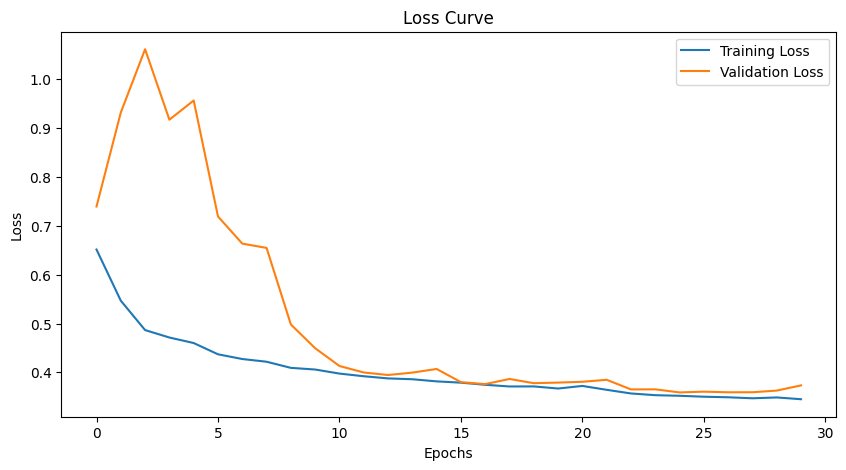

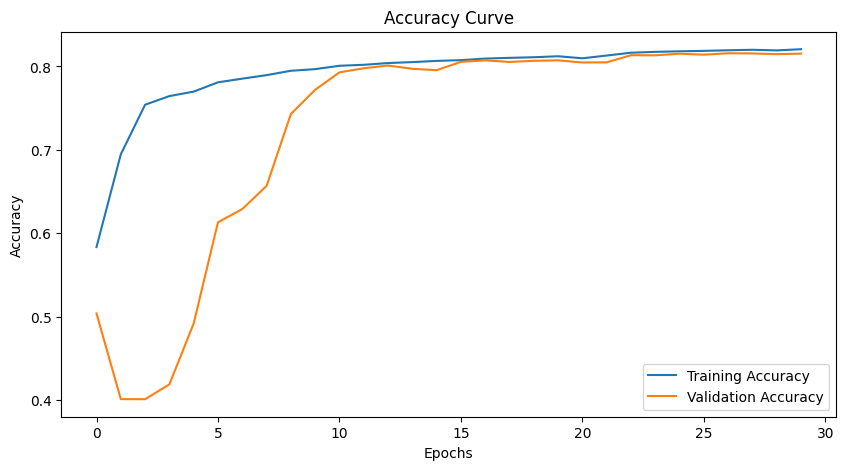

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
# Load the best model weights
model.load_weights("unet_lung_segmentation.h5")

# Evaluate on the validation set
loss, accuracy = model.evaluate(x_valid, y_valid, batch_size=32)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")


20/20 [==============================] - 48s 2s/step - loss: 0.3590 - accuracy: 0.8153
Validation Loss: 0.3589603304862976
Validation Accuracy: 0.8153085708618164


1/1 [==============================] - 0s 111ms/step


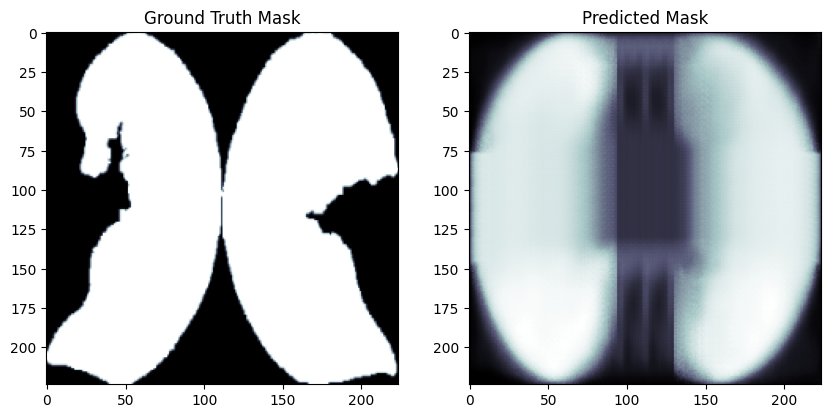

1/1 [==============================] - 0s 114ms/step


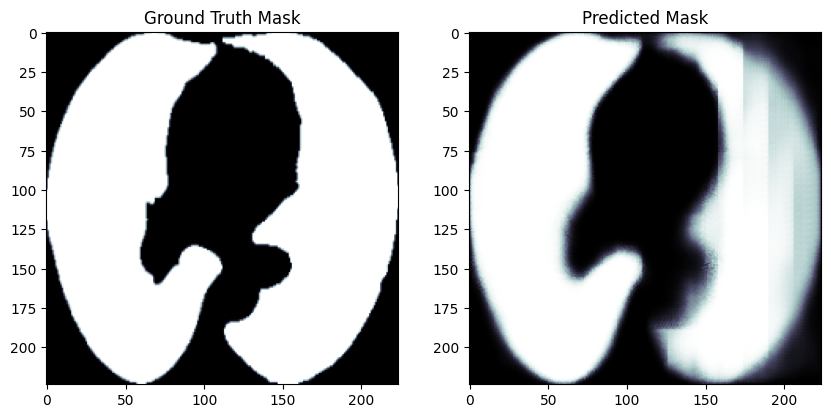

1/1 [==============================] - 0s 102ms/step


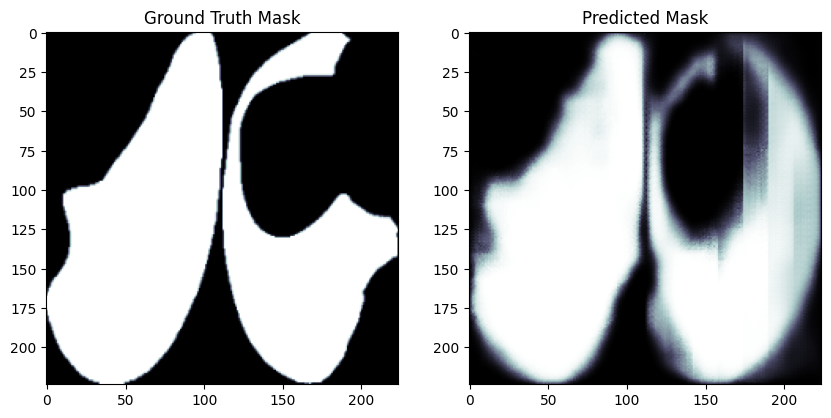

1/1 [==============================] - 0s 111ms/step


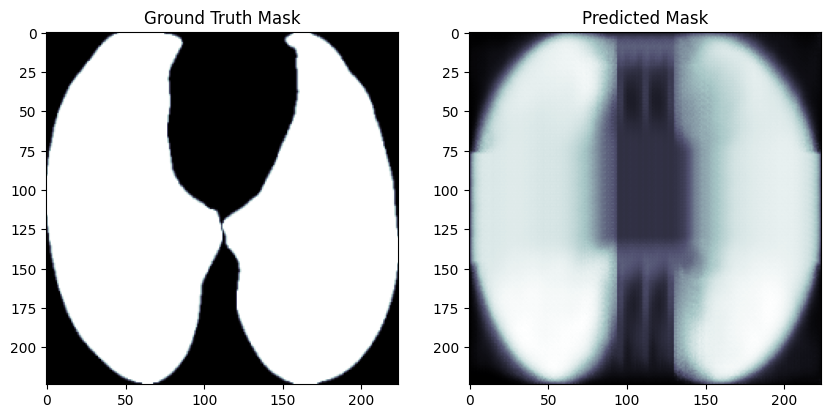

1/1 [==============================] - 0s 105ms/step


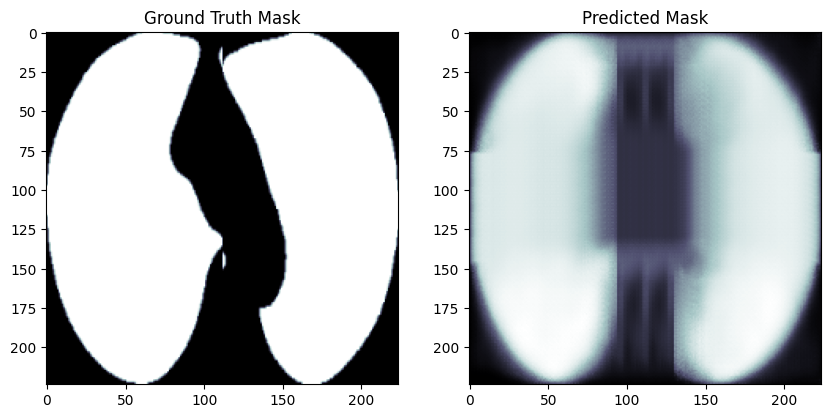

In [16]:
def visualize_masks_only(model, x_data, y_data, index):
    # Predict the mask
    prediction = model.predict(x_data[index].reshape(1, 224, 224, 1))

    # Plot the ground truth and predicted mask
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(y_data[index].reshape(224, 224), cmap='bone')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 2, 2)
    plt.imshow(prediction.reshape(224, 224), cmap='bone')
    plt.title("Predicted Mask")

    plt.show()

# Visualize masks for selected indices
for i in range(110, 115):  # Adjust indices as needed
    visualize_masks_only(model, x_valid, y_valid, i)


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6  # To avoid division by zero
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Intersection over Union (IoU)
def iou_score(y_true, y_pred):
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Precision, Recall, F1-Score
def precision_recall_f1(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    tp = np.sum(y_true_f * y_pred_f)
    fp = np.sum(y_pred_f) - tp
    fn = np.sum(y_true_f) - tp
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    return precision, recall, f1


In [18]:
# Predict on the validation set
y_pred = model.predict(x_valid)
y_pred_binary = (y_pred > 0.5).astype(np.float32)  # Thresholding

# Initialize lists to store metrics
dice_scores = []
iou_scores = []
precisions = []
recalls = []
f1_scores = []

# Calculate metrics for each validation sample
for i in range(y_valid.shape[0]):
    dice = dice_coefficient(y_valid[i], y_pred_binary[i])
    iou = iou_score(y_valid[i], y_pred_binary[i])
    precision, recall, f1 = precision_recall_f1(y_valid[i], y_pred_binary[i])

    dice_scores.append(dice)
    iou_scores.append(iou)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Compute mean metrics
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1_scores)

print(f"Mean Dice Coefficient: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1:.4f}")


20/20 [==============================] - 48s 2s/step
Mean Dice Coefficient: 0.8513
Mean IoU Score: 0.7652
Mean Precision: 0.8419
Mean Recall: 0.8697
Mean F1-Score: 0.8513


In [30]:
import os
import cv2
import numpy as np

# Create a test folder
test_folder = "test_images_lung1"
os.makedirs(test_folder, exist_ok=True)

# Save 5 images from the validation set into the test folder
for i in range(110,115):
    img_path = os.path.join(test_folder, f"test_image_{i+1}.png")
    # Save the image in the range of [0, 255]
    cv2.imwrite(img_path, (x_valid[i] * 255).astype(np.uint8))

print(f"Test images saved in: {test_folder}")


Test images saved in: test_images_lung1


In [31]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained U-Net model
model = load_model("unet_lung_segmentation.h5", compile=False)

# Preprocess function for testing
def preprocess_image(image_path):
    """
    Preprocess a single image for the U-Net model.
    1. Load the image as grayscale.
    2. Resize it to the input size.
    3. Normalize pixel values to [0, 1].
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))  # Resize to the input size
    img = img.astype(np.float32) / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# Prediction function
def predict_mask(image_path):
    """
    Predict the segmented mask for the given image.
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict the mask
    predicted_mask = model.predict(img)[0]

    # Threshold the mask
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

    return img[0], predicted_mask_binary

# Visualization function
def visualize_prediction(image_path):
    """
    Display the input image and its predicted segmentation mask.
    """
    input_img, pred_mask = predict_mask(image_path)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input_img.squeeze(), cmap="bone")
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap="jet")
    plt.title("Predicted Segmentation Mask")

    plt.show()


Available test images:
1. test_image_111.png
2. test_image_112.png
3. test_image_113.png
4. test_image_114.png
5. test_image_115.png
Enter the number of the image you want to test (1-5): 2
Selected image: test_images_lung1/test_image_112.png
1/1 [==============================] - 0s 116ms/step


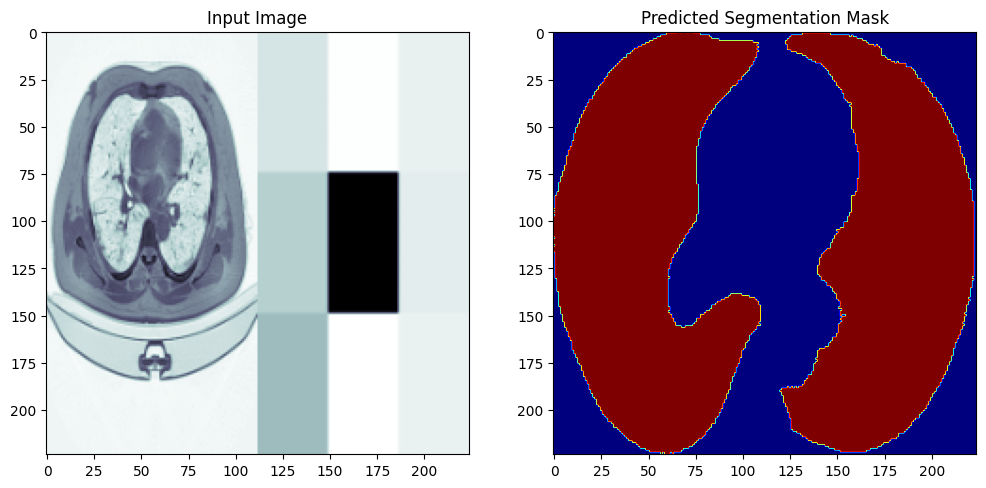

In [37]:
# List test images
test_images = sorted(os.listdir(test_folder))
print("Available test images:")
for i, image_name in enumerate(test_images):
    print(f"{i + 1}. {image_name}")

# Ask the user to select an image by entering the index
selected_index = int(input("Enter the number of the image you want to test (1-5): ")) - 1
if selected_index < 0 or selected_index >= len(test_images):
    print("Invalid selection. Please run the script again.")
else:
    selected_image_path = os.path.join(test_folder, test_images[selected_index])
    print(f"Selected image: {selected_image_path}")

    # Visualize the prediction
    visualize_prediction(selected_image_path)
